In [1]:
%matplotlib inline

import sys
import math
import outliers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

prescription = pd.read_csv('../data/prescriptions_subdose.csv.gz', compression='gzip')

In [2]:
medications = outliers.getOverdoseMedications(prescription)
medications.shape

(74,)

In [3]:
all_times  = []

for med in np.asarray(medications):

    methods_time = pd.DataFrame()
    
    X, Y = outliers.getPrescriptions(prescription, med)
    anomalies = len(Y[Y==1])
    total = len(X)
    
    if len(X) < 30000:
        continue

    print(med + ', Size: ', total, ' Overdose: ', anomalies)
        
    index_list = np.append([], [])
    skf = StratifiedKFold(n_splits=anomalies)
    div = 1
    for train_index, test_index in skf.split(X, Y):
            
            
        index_list = np.append(index_list.astype(int), test_index.astype(int))
        size = len(index_list)
            
        X_train = X[index_list]
        Y_train = Y[index_list]
        overdose_size = len(Y_train[Y_train==1])
        
        if (size // 3000) < div:
            continue
            
        size_idx = div * 3000
        div = 1 + (size // 3000)
        
        sys.stdout.write(str(overdose_size) + '/' + str(size) +', ')
            
        epsilon = 0.5
        p_svm = [epsilon,4]
        p_cov = [epsilon]
        p_ift = [epsilon]
        p_lof = [500,epsilon]
        p_wpr = [epsilon]
        p_gmx = [epsilon]
        results = outliers.evaluateMethods(X_train, Y_train, p_svm, p_cov, p_ift, p_lof, p_wpr, p_gmx, debug=False)

        for idx in results.index:
            methods_time.loc[idx, size_idx] = results.loc[idx,'Time']

        if size > 30000:
            break

    all_times.append(methods_time)
        #break
    
    if len(all_times) > 5:
        break
            
print('Done')

DIPIRONA 1 g/2 ml SOL INJ, Size:  163027  Overdose:  651
12/3012, 24/6024, 36/9036, 48/12048, 60/15060, 72/18072, 84/21084, 96/24096, 108/27108, 120/30120, LACTULOSE 667 mg/ml SOL ORAL, Size:  33395  Overdose:  207
19/3078, 38/6156, 56/9072, 75/12143, 93/15041, 112/18100, 131/21159, 149/24057, 168/27116, 186/30014, Done


In [4]:
all_times[1]

,3000,6000,9000,12000,15000,18000,21000,24000,27000,30000
Cov,0.470,0.532,0.613,0.746,0.814,0.979,1.091,1.266,1.515,1.625
IsoF,0.195,0.279,0.356,0.469,0.543,0.638,0.742,0.834,0.925,0.999
LOF,0.399,0.861,1.419,1.961,2.516,3.156,3.885,4.340,5.004,5.331
SVM,0.234,0.922,1.992,3.655,5.665,8.319,11.583,15.255,19.419,24.128
Gau,0.011,0.011,0.022,0.023,0.027,0.032,0.037,0.036,0.055,0.044
DDC,0.043,0.048,0.056,0.069,0.075,0.078,0.080,0.100,0.107,0.117
DDC-C,0.061,0.070,0.086,0.109,0.120,0.122,0.124,0.178,0.192,0.218
DDC-J,0.036,0.040,0.046,0.055,0.059,0.062,0.064,0.075,0.080,0.085


In [6]:
mean_time = pd.DataFrame(np.zeros((8,10)), index=results.index, columns=np.arange(3000,30001,3000))

for df in all_times:
    for m in df.index:
        for s in df.columns:
            mean_time.loc[m,s] += df.loc[m,s]

mean_time = ( mean_time.values / len(all_times) )
mean_time = pd.DataFrame(mean_time, index=results.index, columns=np.arange(3000,30001,3000))
mean_time

,3000,6000,9000,12000,15000,18000,21000,24000,27000,30000
Cov,0.3665,0.4430,0.5135,0.6160,0.6855,0.8295,0.9320,1.0805,1.2590,1.3735
IsoF,0.1820,0.2540,0.3250,0.4145,0.4900,0.5705,0.6605,0.7450,0.8215,0.9030
LOF,0.4040,0.9175,1.5980,2.2765,2.9800,3.9305,4.8140,5.6735,6.7000,7.6110
SVM,0.1725,0.6940,1.5350,2.7525,4.2720,6.2100,8.5580,11.2785,14.3425,17.7745
Gau,0.0085,0.0100,0.0165,0.0185,0.0215,0.0255,0.0290,0.0300,0.0405,0.0365
DDC,0.0300,0.0330,0.0395,0.0475,0.0525,0.0545,0.0570,0.0670,0.0725,0.0780
DDC-C,0.0390,0.0450,0.0555,0.0690,0.0765,0.0785,0.0805,0.1085,0.1175,0.1315
DDC-J,0.0255,0.0290,0.0340,0.0400,0.0435,0.0460,0.0480,0.0545,0.0585,0.0615


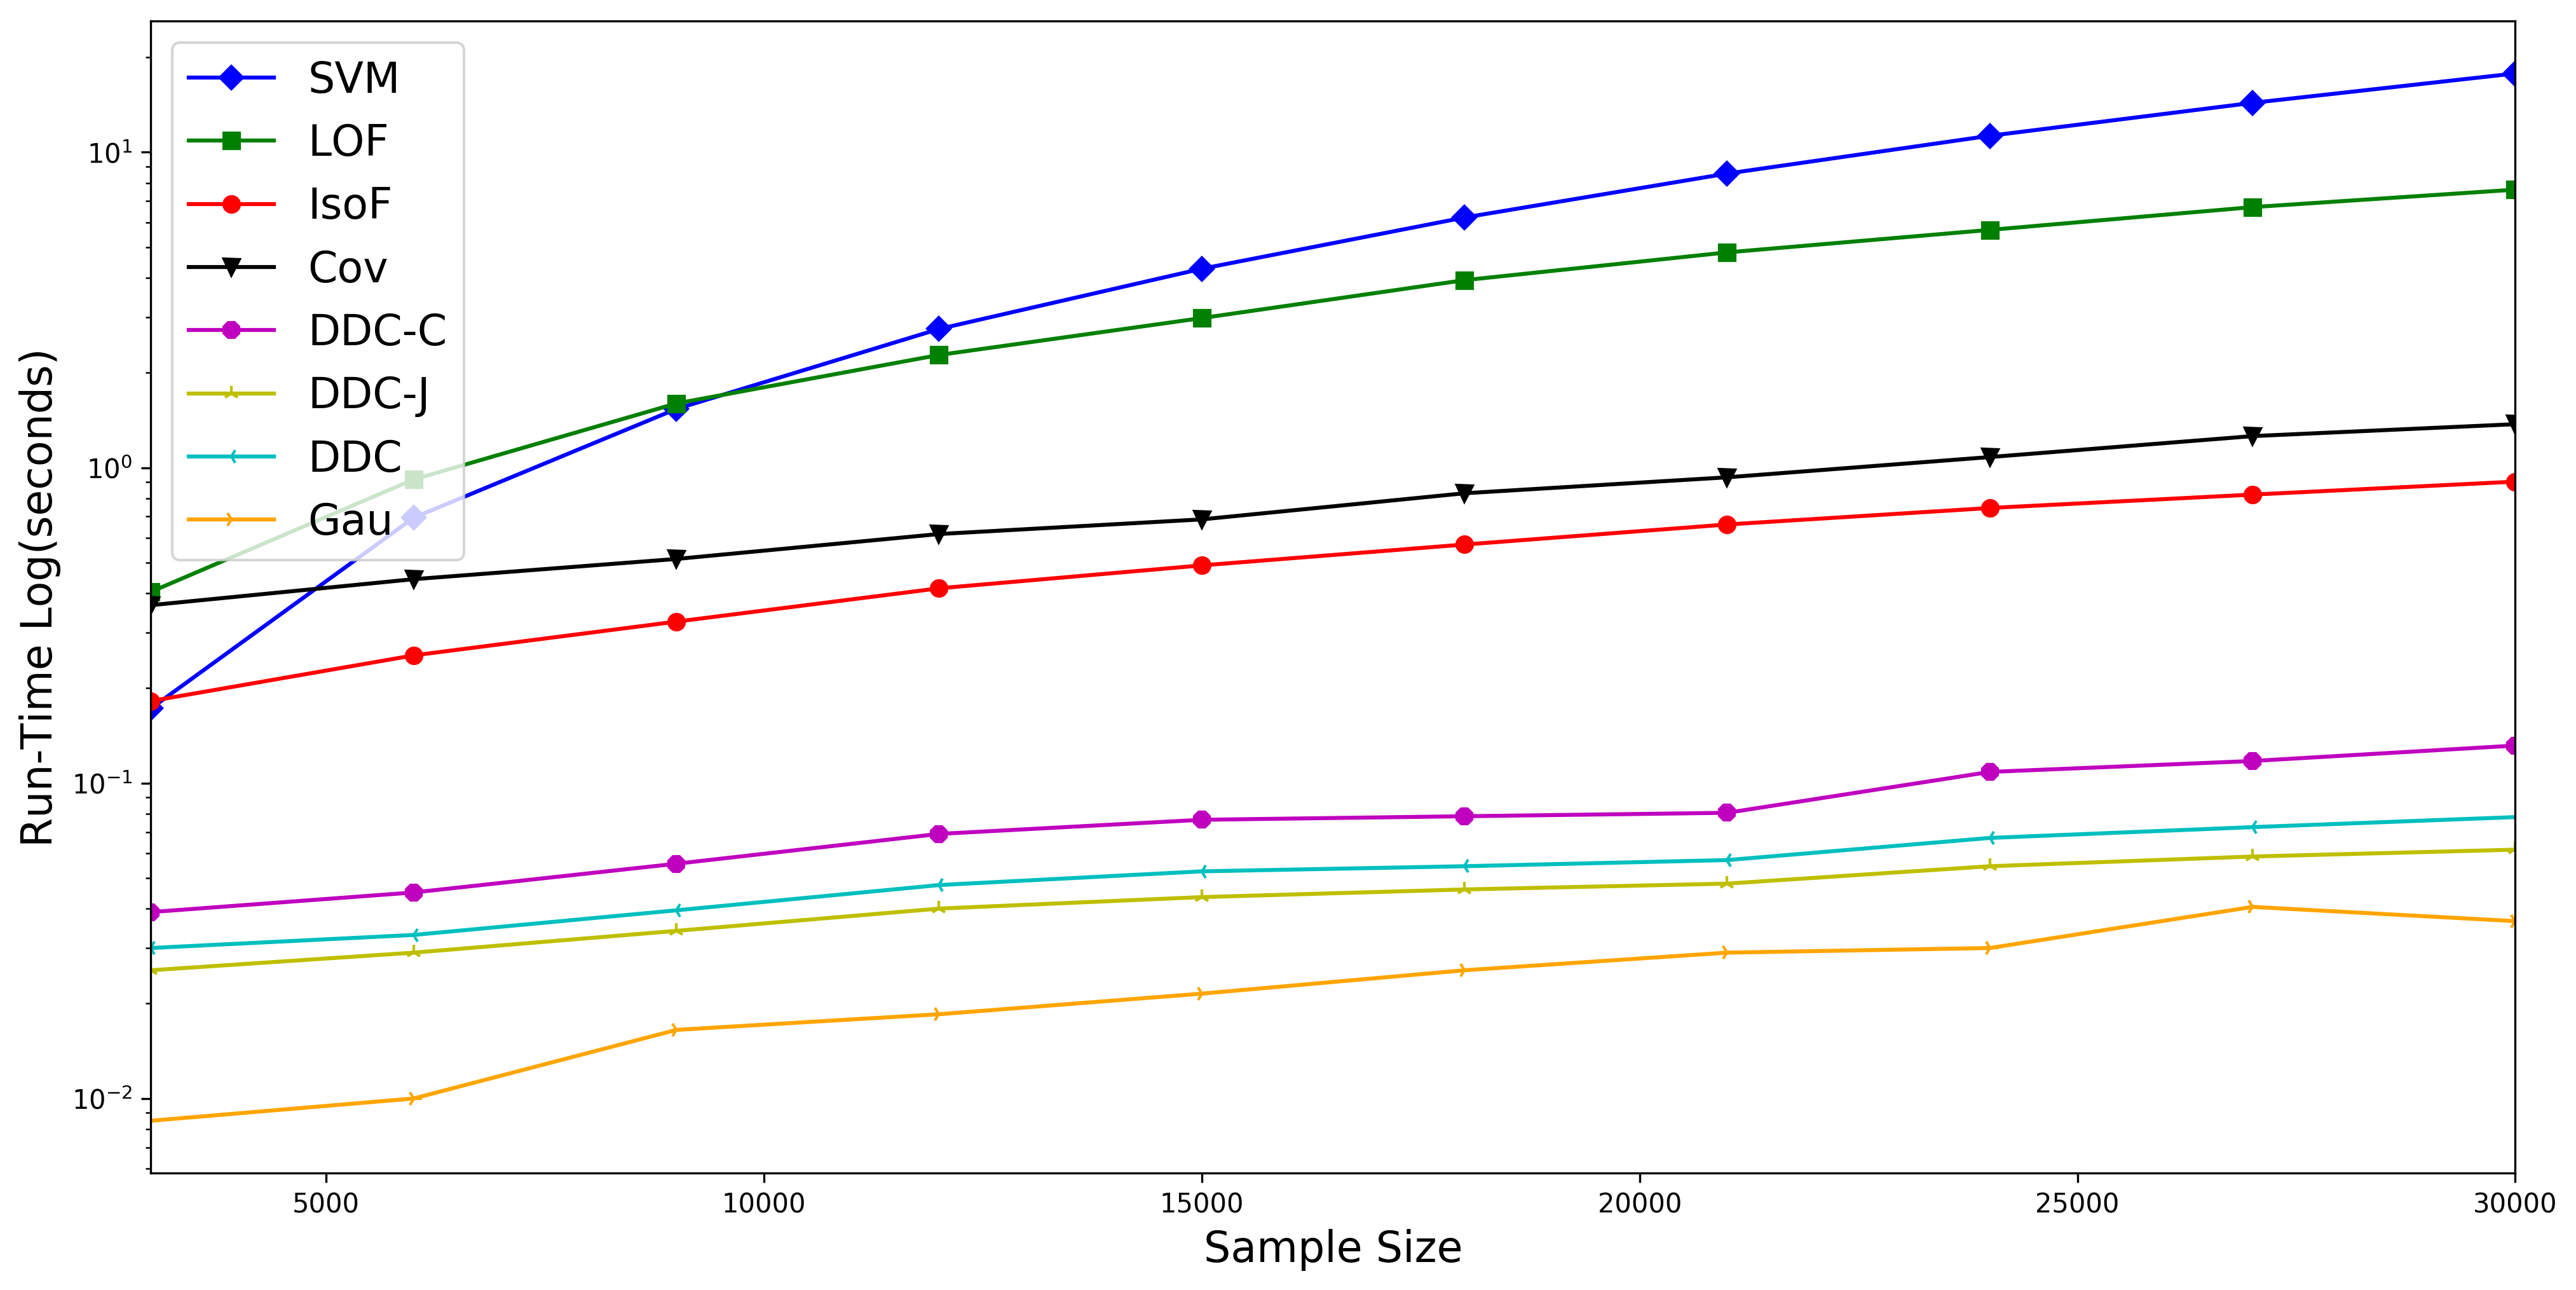

In [8]:
plt.figure(figsize=(16, 8), dpi= 300)
methods = ['SVM','LOF','IsoF','Cov','DDC-C','DDC-J','DDC','Gau']
colors = ['b', 'g', 'r', 'k', 'm', 'y', 'c', 'orange', 'brown']
markers = ['D', 's', 'o', 'v', '8', '2', '3', '4', '1']
i = 0
for m in methods:
    plt.plot(np.asarray(mean_time.columns),np.asarray(mean_time.loc[m].values), 
             c=colors[i],
             marker=markers[i],
             label=m)
    i += 1
    
plt.legend(fontsize=16)
plt.xlabel('Sample Size', fontsize=16)
plt.ylabel('Run-Time Log(seconds)', fontsize=16)
plt.yscale('log')
plt.xlim(3000,30000)
plt.show()